In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import scipy
from tqdm import tqdm

In [2]:
video_path = 'inputs/PXL_20241220_231952124.mp4'
 
cap = cv.VideoCapture(video_path)

desired_fps = 7
frame_count_total = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
duration = frame_count_total/cap.get(cv.CAP_PROP_FPS)

frame_skip_interval = int(np.round(cap.get(cv.CAP_PROP_FPS) / desired_fps))
imgs = []
frame_count = 1
while frame_count < frame_count_total:
    ret, frame = cap.read()

    if (np.mod(frame_count, frame_skip_interval) == 0):

      frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      if frame.shape[1]>frame.shape[0]:
        frame = np.flipud(frame.T)
      img = cv.resize(frame, (int(frame.shape[1]/4), int(frame.shape[0]/4)))
      imgs.append(img)

    frame_count += 1

cap.release()

In [3]:
bar_height = 50

In [4]:
def get_features(im, bar_height):

  bar = np.ones((2*bar_height, 16))
  bar[int(bar_height/2):int(3*bar_height/2), :] = -1
  im2 = scipy.signal.convolve2d(im, bar, 'same')
  
  bar_ind_x = int(im.shape[1]/4)
  slice = im2[:, bar_ind_x]
  bar_ind_y = np.argmax(slice)

  bar_patch = im[bar_ind_y-bar_height: bar_ind_y+bar_height,bar_ind_x-2: bar_ind_x+2]
  edges = cv.Canny(bar_patch,100, 255)
  edges = np.sum(edges, axis=1)
  edges_top = edges[:bar_height] 
  edges_bottom = edges[bar_height:] 
  bar_ind_top = np.argmax(edges_top)+bar_ind_y -len(edges_bottom)
  bar_ind_bottom = np.argmax(edges_bottom)+bar_ind_y
  bar_height = bar_ind_bottom - bar_ind_top

  return im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height

def get_features_minimal(im, bar_height):
  bar_ind_x = int(im.shape[1]/4)

  bar = np.ones(2*bar_height)
  bar[int(bar_height/2):int(3*bar_height/2)] = -1

  slice = im[:, bar_ind_x:bar_ind_x+5]  
  im2 = np.sum(slice, axis=1)
  im2 = np.convolve(im2, bar, 'same')
  bar_ind_y = np.argmax(im2)

  bar_patch = im[bar_ind_y-bar_height: bar_ind_y+bar_height,bar_ind_x-2: bar_ind_x+2]
  edges = cv.Canny(bar_patch,100, 255)
  edges = np.sum(edges, axis=1)
  edges_top = edges[:bar_height] 
  edges_bottom = edges[bar_height:] 
  bar_ind_top = np.argmax(edges_top)+bar_ind_y -len(edges_bottom)
  bar_ind_bottom = np.argmax(edges_bottom)+bar_ind_y
  bar_height = bar_ind_bottom - bar_ind_top

  return im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height

def plot_frame_minimal(im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height):
  plt.figure(figsize=(12, 4))

  ax1 = plt.subplot(1, 4, 1)
  plt.imshow(im)
  ax2 = plt.subplot(1, 4, 2)
  plt.scatter(np.arange(len(im2)), im2)

  ax3 = plt.subplot(1, 4, 3)  
  #plt.scatter(np.arange(len(slice)), slice)
  plt.imshow(slice)

  plt.subplot(1, 4, 4)
  plt.imshow(bar_patch)
  plt.sca(ax1)
  plt.scatter(bar_ind_x, bar_ind_top)
  plt.scatter(bar_ind_x, bar_ind_bottom)

def plot_frame(im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height):
  plt.figure(figsize=(12, 4))

  ax1 = plt.subplot(1, 4, 1)
  plt.imshow(im)
  ax2 = plt.subplot(1, 4, 2)
  plt.imshow(im2)

  ax3 = plt.subplot(1, 4, 3)  

  plt.scatter(np.arange(len(slice)), slice)

  plt.subplot(1, 4, 4)
  plt.imshow(bar_patch)
  plt.sca(ax1)
  plt.scatter(bar_ind_x, bar_ind_top)
  plt.scatter(bar_ind_x, bar_ind_bottom)

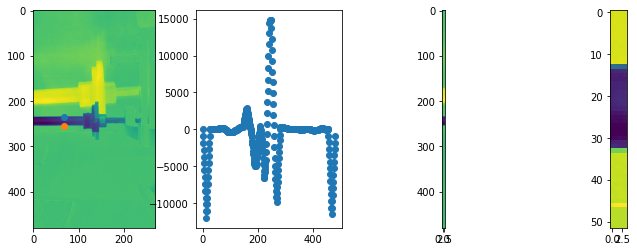

In [5]:
imgs_avg = np.mean(np.array(imgs), axis=0)

bar_height = 26
im = imgs[50]-imgs_avg
im = (im - np.min(im)) / (np.max(im) - np.min(im))
im = np.uint8(im * 255)
im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height = get_features_minimal(im, bar_height)
plot_frame_minimal(im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height)

In [6]:
bar_height=24
bar_heights = []
for im in tqdm(imgs):
  im = im-imgs_avg
  im = (im - np.min(im)) / (np.max(im) - np.min(im))
  im = np.uint8(im * 255)
  im, im2, slice, bar_patch, bar_ind_top, bar_ind_bottom, bar_ind_x, bar_height_new = get_features_minimal(im, bar_height)
  #if np.abs(bar_height-bar_height_new)< 5:
  #  bar_height = bar_height_new

  bar_heights.append(bar_height_new)

100%|██████████| 247/247 [00:00<00:00, 1391.39it/s]


In [7]:
t = np.linspace(0, duration, len(bar_heights))

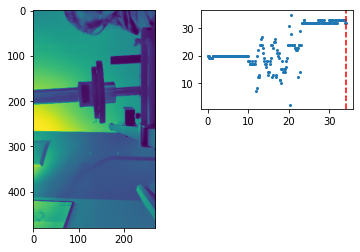

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ax1 = plt.subplot(1, 2, 1)

ax1_im = ax1.imshow(imgs[0], cmap='viridis')

ax2 = plt.subplot(2, 2, 2)
plt.scatter(t, bar_heights, s=4)
plt.xlabel('time (s)')
ax2_plt = ax2.axvline(x=0, color='red', linestyle='--') 

def animate(i): 
  ax1_im.set_data(imgs[i])
  ax2_plt.set_xdata(t[i]) 
  return [ax1_im, ax2_plt]


ani = animation.FuncAnimation(fig, animate, frames=len(imgs), interval=1/desired_fps*1000, blit=True)
ani.save('animation.mp4')

In [22]:
dir(ax2_plt)

['_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_callbacks',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_color',
 '_dashOffset',
 '_dashSeq',
 '_dashcapstyle',
 '_dashjoinstyle',
 '_default_contains',
 '_drawStyles_l',
 '_drawStyles_s',
 '_drawstyle',
 '_get_clipping_extent_bbox',
 '_get_markerfacecolor',
 '_get_transformed_path',
 '_gid',
 '_in_layout',
 '_invalidx',
 '_invalidy',
 '_is_sorted',
 '_label',
 '_lineStyles',
 '_linestyle',
 '_linestyles',
 '_linewidth',
 '_marker',
 '_markeredgecolor',
 '_markeredgewidth',
 '_markerfacecolor

### Math

In [54]:
def collatz(n):
  if np.mod(n, 2)==0:
    return n/2
  else:
    return 3*n+1

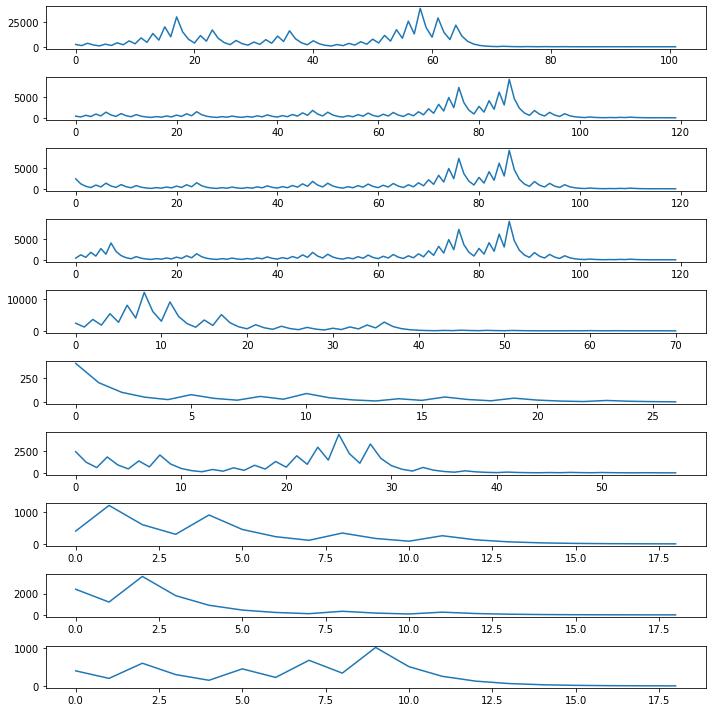

In [ ]:
n_starts = np.arange(795, 805)
plt.figure(figsize=(10, len(n_starts)))
for n_start in n_starts:
  ns = []
  n = n_start
  while True:
    n = collatz(n)
    if n ==1:
      break
    ns.append(n)
  plt.subplot( len(n_starts),1, n_start-n_starts[0]+1)
  plt.plot(np.arange(len(ns)), ns)
  #plt.title(str(n_start))
plt.tight_layout()

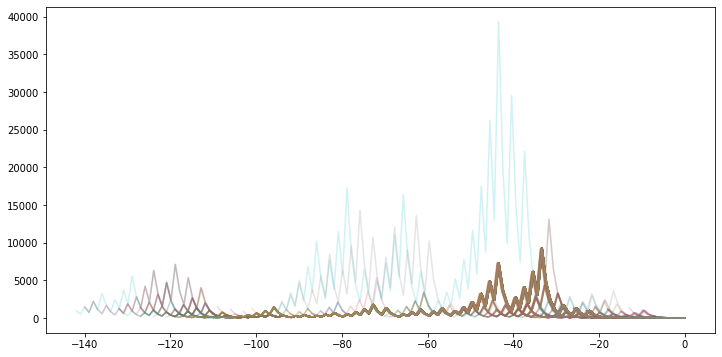

In [ ]:
n_start = 8
n_starts = np.arange(n_start, n_start+500)
plt.figure(figsize=(12, 6))
for n_start in n_starts:
  ns = []
  n = n_start
  while True:
    n = collatz(n)
    if n ==1:
      break
    ns.append(n)
  plt.plot(np.linspace(-len(ns), 0, len(ns)), ns, alpha=0.2)
  #plt.title(str(n_start))
#plt.ylim([0,100])

In [57]:
np.linspace(-len(ns), 0)

array([-34.        , -33.30612245, -32.6122449 , -31.91836735,
       -31.2244898 , -30.53061224, -29.83673469, -29.14285714,
       -28.44897959, -27.75510204, -27.06122449, -26.36734694,
       -25.67346939, -24.97959184, -24.28571429, -23.59183673,
       -22.89795918, -22.20408163, -21.51020408, -20.81632653,
       -20.12244898, -19.42857143, -18.73469388, -18.04081633,
       -17.34693878, -16.65306122, -15.95918367, -15.26530612,
       -14.57142857, -13.87755102, -13.18367347, -12.48979592,
       -11.79591837, -11.10204082, -10.40816327,  -9.71428571,
        -9.02040816,  -8.32653061,  -7.63265306,  -6.93877551,
        -6.24489796,  -5.55102041,  -4.85714286,  -4.16326531,
        -3.46938776,  -2.7755102 ,  -2.08163265,  -1.3877551 ,
        -0.69387755,   0.        ])

In [ ]:
n_start

507

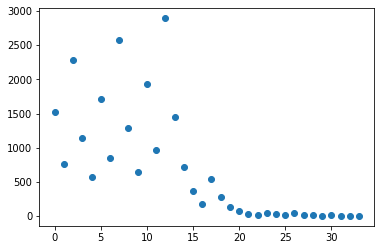

In [59]:
plt.scatter(np.arange(len(ns)), ns)